In [1]:
# 코랩을 사용하지 않으면 이 셀의 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=4)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 532, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 532 (delta 161), reused 184 (delta 107), pack-reused 266
Receiving objects: 100% (532/532), 45.97 MiB | 14.87 MiB/s, done.
Resolving deltas: 100% (260/260), done.
/kaggle/working/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.20.1
Using datasets v2.1.0
Using accelerate v0.12.0
Using sentencepiece v0.1.97
Using seqeval


# 다중 언어 개체명 인식
- 다중 언어 트랜스포머는 많은 언어로 된 대규모 말뭉치에서 사전 훈련해서 제로샷 교차 언어 전이가 가능하다
- 한 언어에서 미세 튜닝된 모델이 추가 훈련 없이 다른 언어에 적용 된다는 의미이다.
- 또 이런 모델은 한 대화에서 둘 이상의 언어나 사투리를 바꾸는 코드 스위칭에 적합하다.
- 이 장에서는 XLM-RpBERTa 트랜스포머 모델을 개체명 인식을 수행하도록 여러 언어에서 미세 투닝하는 방법을 알아보겠다.
- NER은 텍스트에서 사람, 조직, 위치 같은 개체명을 식별하는 일반적은 NLP작업으로 다양한 애플리케이션에서 사용한다.
- 가량 회사 문서에서 중요한 정보를 추출하거나, 검색 엔진의 품질을 높이거나, 말뭉치에서 구조적인 데이터베이스를 만든다.

In [2]:
import pandas as pd
toks = "Jeff Dean is a computer scientist at Google in California".split()
lbls = ["B-PER", "I-PER", "O", "O", "O", "O", "O", "B-ORG", "O", "B-LOC"]
df = pd.DataFrame(data=[toks, lbls], index=['Tokens', 'Tags'])
df

,0,1,2,3,4,5,6,7,8,9
Tokens,Jeff,Dean,is,a,computer,scientist,at,Google,in,California
Tags,B-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC


In [3]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names('xtreme')
print(f'XTREME 서브셋 개수 : {len(xtreme_subsets)}')

XTREME 서브셋 개수 : 183


In [4]:
panx_subsets = [s for s in xtreme_subsets if s.startswith('PAN')]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [5]:
from datasets import load_dataset

load_dataset('xtreme', name='PAN-X.de')

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [6]:
from collections import defaultdict
from datasets import DatasetDict

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
# 키가 없는 경우 DatasetDict를 반환합니다.
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # 다국어 말뭉치를 로드합니다.
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # 각 분할을 언어 비율에 따라 다운샘플링하고 섞습니다.
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows))))

  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
import pandas as pd

pd.DataFrame({lang : [panx_ch[lang]['train'].num_rows] for lang in langs},
             index=['Number of training examples'])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [8]:
element = panx_ch['de']['train'][0]
for key, value in element.items():
  print(f'{key} : {value}')

tokens : ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der',
'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags : [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs : ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [9]:
for key, value in panx_ch['de']['train'].features.items():
  print(f'{key}:{value}')

tokens:Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags:Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER',
'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs:Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [10]:
tags = panx_ch['de']['train'].features['ner_tags'].feature
print(tags)

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG',
'B-LOC', 'I-LOC'], id=None)


In [11]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)

  0%|          | 0/12580 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

In [12]:
de_example = panx_de['train'][0]
pd.DataFrame([de_example['tokens'], de_example['ner_tags_str']], ['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [13]:
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
  for row in dataset['ner_tags_str']:
    for tag in row:
      if tag.startswith('B'):
        tag_type = tag.split('-')[1]
        split2freqs[split][tag_type] += 1

pd.DataFrame.from_dict(split2freqs, orient='index')

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


## 2. 다중 언어 트랜스포머
- 다중 언어 트랜스포머의 훈련 과정과 아키텍처는 단일 언어 트랜스포머와 비슷하다.
- 다만 사전훈련에 사용하는 말뭉치가 여러 언어의 문서로 구성될 뿐이다.
- 언어의 차이에 대한 정보가 명시적으로 제공되지 않아도, 이렇게 구축한 언어 표현이 여러 언어의 다양한 후속 작업에 쉽게 일반화된다는 점이 놀라운 특징이다.
- 교차 언어 전이를 수행하는 이런 능력이 경우에 따라 단일 언어 모델과 비슷한 결과를 내므로 언어마다 별도의 모델 훈련을 할 필요가 없다.

## 3.XLM-R 토큰화
- XLM-R은 WordPiece 토크나이저 대신 100개 언어의 텍스트에서 훈련도니 SentencePiece라는 토크나이저를 사용한다.
- SentencePiece를 WordPiece와 비교하기 위해 트랜스포머스로 BERT와 XLM-R의 토크나이저를 로드하겠다.

In [14]:
from transformers import AutoTokenizer

bert_model_name = 'bert-base-cased'
xlmr_model_name = 'xlm-roberta-base'
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

In [15]:
text = 'Jack Sparrow loves New York!'
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [16]:
df = pd.DataFrame([bert_tokens, xlmr_tokens], index=["BERT", "XLM-R"])
df

,0,1,2,3,4,5,6,7,8,9
BERT,[CLS],Jack,Spa,##rrow,loves,New,York,!,[SEP],None
XLM-R,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>


### 1) 토큰화 파이프라인
- 지금까지 토큰화를 다룰 때 문자열을 모델에 주입할 정수로 변환하는 연산으로만 여겼는데 전적으로 옳은것은 아니다.
- 실제로는 정규화, 사전 토큰화, 토크나이저 모델, 사후 처리 이 네 단게로 구성된다.

- 정규화
    - 이 단계는 원시 문자열을 더 깨끗하게 만들기 위해 적용하는 일련의 연산에 해당한다.
- 사전 토큰화
    - 이 단계는 텍스트를 더 작은 객체로 분할하며 훈련 마지막에 생성되는 토큰의 상한선을 제공한다.
    - 사전 토큰화가 텍스트를 단어로 분할하고 최종 토큰은 이 단어의 일부가 된다고 생각하면 좋다.
- 토크나이저 모델
    - 입력 텍스트 정규화와 사전 토큰화를 수행하고 난 후 토크나이저를 사용해 부분단어 분할 모델을 단어에 적용한다.
    - 토크나이저는 파이프라인에서 말뭉치로 훈련이 필요한 부분이다.
- 사후 처리
    - 토큰화 파이프라인의 마지막 단계로, 토큰 리스트에 부가적인 변호나을 적용할 때도 있다.
    - 가령 입력 토큰 인덱스의 시퀀스 처음과 끝에 특수 토큰을 추가하는 경우이다.

### 2) SentencePiece 토크나이저
- SentencePiece 토크나이저는 유니그램이라는 부분단어 분할 방식을 기반으로 각 입력 텍스트를 유니코드 문자 시퀀스로 인코딩한다.
- SentencePiece가 악섹트, 구두점에 대해 몰라도 되므로 이 특징은 다국어 말뭉치에 특히 유용하다.
- 일본어 등 많은 언어에 공백 문자가 있지 않다는 사실을 몰라도 된다.
- SentencePiece의 또 다른 고유한 특징은 공백 문자가 유니코드 기호 U+2581 또는 아래 1/4qmffhr answkfkrheh gksms _ 문자에 할당된다는 것이다.
- 따라서 SentencePiece는 언어별 사전 토크나이저에 의존하지 않고 정확하게 시퀀스를 복원한다.

In [17]:
"".join(xlmr_tokens).replace(u"\u2581", " ")

'<s> Jack Sparrow loves New York!</s>'

## 4. 개체명 인식을 위한 트랜스포머
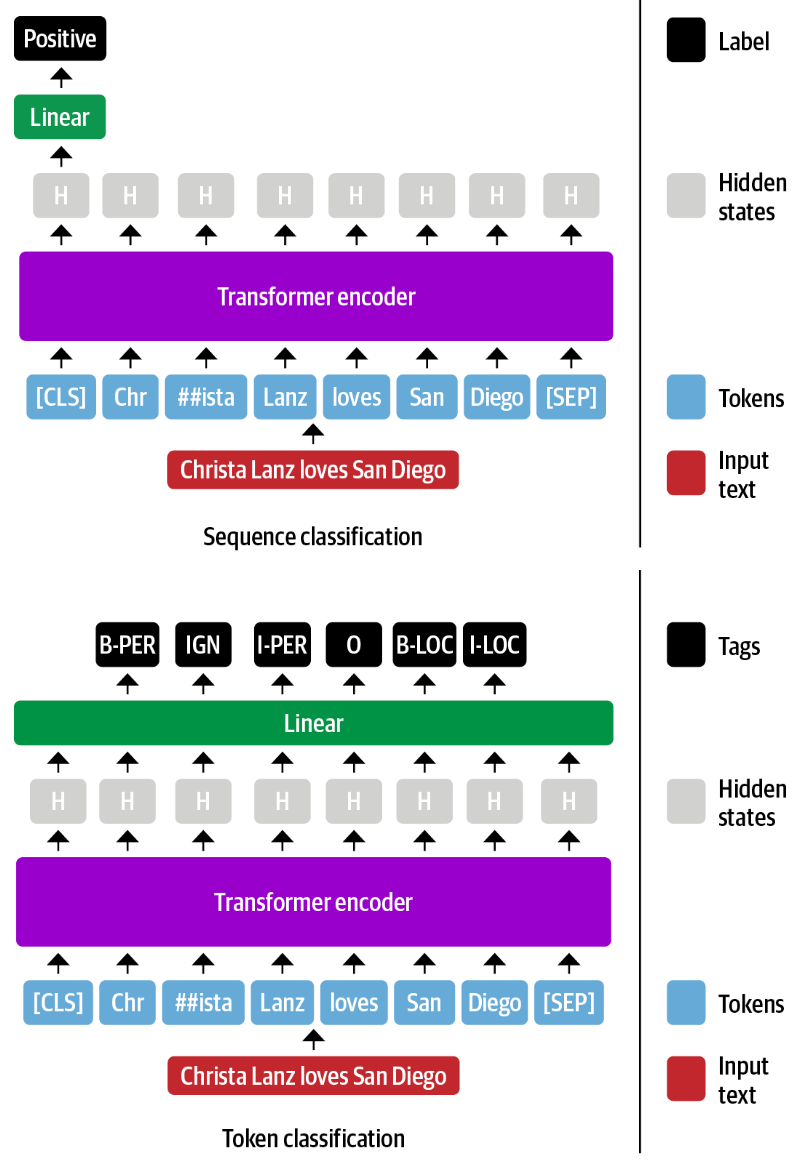
- 텍스트 분류를 위해 BERT는 특수 토큰 [CLS]로 전체 텍스트를 시퀀스를 표현한다.
- 이 표현을 완전 연결 또는 밀집 층에 통과시켜 이산적인 레이블 값을 출력한다.
- BERT와 그 외 인코더 기반 트랜스포머는 NER 작업에 비슷한 방식을 사용한다.
- 다만 모든 입력 토큰의 표현이 완전 연결 층에 주입되어 해당 토큰의 개체명을 인식한다.
- 이런 이유로 NER을 종종 토큰 분류 작업으로 생각하기도 한다.


- 토큰 분류 작업에서 부분단어를 어떻게 처리해야할까?



## 5. 트랜스포머 모델 클래스
- 트랜스포머는 기존 모델을 특정 작업에 맞게 쉽게 확장 가능하도록 설계됐다.
- 사전 훈련된 모델에서 가중치를 로드하고 작업에 특화된 헬퍼 함수를 사용한다.
- 아주 조금만 수고하면 특정 용도의 사용자 정의 모델을 만들 수 있다.

### 1) 바디와 헤드
- 트랜스포머의 다재다능한 능력은 body와 head로 나뉜 모델 구조에서 나온다.
- 이 구조는 사전 훈련도니 모델을 후속 작업에 맞게 바꿀 때 이미 보았다.
- 모델의 마지막 층이 후속 작업에 맞는 층으로 바뀌는데, 이 마지막 층이 모델의 헤드이며 작업에 특화된다.
- 모델의 나머지 부분을 body라고 한다. 여기에는 작업에 특화되지 않은 토큰 임베딩과 트랜스포머 층이 포함된다.
- 이 구조는 transformers 코드에도 반영된다.
    - 모델의 body는 BERTModel 또는 GPT2Model 같은 클래스로 구현되어 body에 있는 마지막 층의 은닉상태를 반환한다.
    - BertForMaskedLM 또는 BertForSequenceClassification 같이 작업에 특화된 모델은 베이스 모델을 사용하고 마지막 은닉 상태 위에 필요한 헤드를 추가하는 것이다.
    - body와 head가 분리된 구조 덕분에 특정 작업을 위해 만든 사용자 정의 헤드를 사전 훈련도니 모델이 장착할 수 있습니다.


### 2) 토큰 분류를 위한 사용자 정의 모델 만들기

In [18]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # 모델 바디를 로드합니다.
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # 토큰 분류 헤드를 준비합니다.
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # 가중치를 로드하고 초기화합니다.
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        # 모델 바디를 사용해 인코더 표현을 얻습니다.
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # 인코더 표현을 헤드에 통과시킵니다.
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # 손실을 계산합니다.
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # 모델 출력 객체를 반환합니다.
        return TokenClassifierOutput(loss=loss, logits=logits, 
                                     hidden_states=outputs.hidden_states, 
                                     attentions=outputs.attentions)

- config_class는 새로운 모델을 초기화할 때 표준 XLM-R 설정을 사용하도록 도와준다.
- 기본값을 바꾸고 싶다면 기본 설정을 덮어쓰면 된다.
- super() 메서드로 RobertaPreTrainedModel 클래스의 초기화 함수를 호출한다.
- 이 추상 클래스는 사전 훈련된 가중치의 초기화나 로딩을 처리한다.
- 그 다음 모델 body RobertaModel을 로드하고 드랍아웃 층과 피드 포워드 층으로 구성된 분류 헤드를 추가한다.
- add_pooling_layer=False로 지정해 [CLS] 토큰에 해당하는 은닉 상태 외에 모든 은닉 상태가 반환되도록 한다.
- 마지막으로 RobertaPreTrainedModel 클래스에서 상속된 init_weights() 메서드를 호출해 가중치를 초기화한다.
- 모델 바디에서 사전 훈련된 가중치가 로드되고 토큰 분류 헤드의 가중치가 랜덤하게 초기화 될 것이다.

- 이제 남은 작업은 정방향 패스에서 forward() 메서드로 모델이 할 일을 정의하는 것이다.
- 정방향 패스 과정에서 데이터는 먼저 모델의 바디에 주입된다.
- 여러개의 입력 변수가 있지만 지금 필요한 것은 input_ids와 attention_mask뿐이다.
- 그다음 모델 바디가 출력한 은닉상태를 드롭아웃 층과 분류층에 통과시킨다.
- 정방향 패스에서 레이블을 전달했다면 바로 손실이 계산된다.
- 어텐션 마스크가 있다면 마스킹되지 않은 토큰의 손실만 계산하기 위해 해야할 일이 조금 더 많다.
- 마지막으로 2장에서 소개한 네임드 튜플로 원소를 참조할 수 있도록 출력을 TokenClassifierOUtput 객체로 감쌉니다.

### 3) 사용자 정의 모델 로드하기
- 각 개체명을 레이블링 하는 데 사용할 태그, 각 태그를 ID로 매핑하는 딕셔너리와 그 반대로 매핑하는 딕셔너리를 추가해야한다.
- 이런 정보는 모두 ClassLabel 객체인 tags 변수의 names 속성을 사용해 매핑된다.

In [19]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

- AutoConfig 객체에 이런 매핑과 tags.num_classes 속성을 저장하겠다.
- from_pretrained() 메서드의 키워드 매개변수로 전달해 기본값을 오버라이드한다.

In [20]:

from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, 
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

- AutoConfig 클래스는 모델 구조의 청사진을 가진다.
- AutoModel.from_pretrained(model_ckpt)로 모델을 로드할 때 모델에 연관된 설정 파일이 자동으로 다운로드 된다.
- 하지만 클래스 개수나 레이블 이름 등을 수정하고 싶다면 커스터마이징하려는 매개변수로 이 설정 파일을 먼저 로드한다.
- 이제 config 매개변수를 추가한 다음, 이전처럼 from_pretrained()함수를 사용해 모델 가중치 로드를 한다.
- 모델 클래스에서 사전 훈련된 가중치를 로드하는 코드를 작성하지 않았지만
- RobertaPreTrainedModel을 상속했으니 다음과 같이 로드할 수 있다.

In [21]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

- 토크나이저와 모델을 바르게 초기화했는지 빠르게 확인하기 위해 개체명을 알고있는 작은 시퀀스의 예측 결과를 보겠다.

In [22]:
input_ids = xlmr_tokenizer.encode(text, return_tensors='pt')
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=['Tokens','Input IDs'])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


- 마지막으로 모델에 입력 ID를 전달하고 argmax 함수로 토큰마다 확률이 가장 높은 클래스를 선택해 예측을 만든다.

In [23]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f'시퀀스에 있는 토큰 개수 : {len(xlmr_tokens)}')
print(f'출력 크기 : {outputs.shape}')

시퀀스에 있는 토큰 개수 : 10
출력 크기 : torch.Size([1, 10, 7])


- 로짓의 크기는 [batch_size, num_tokens, num_tags] 이다.
- 즉, 각 토큰에는 입곱 개의 NER 태크와 로짓이 주어진다.
- 사전훈련된 모델의 예측 결과를 태그 이름으로 바꿔 토큰과 함께 확인해보겠다.

In [24]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-LOC,B-LOC,B-PER,B-LOC,B-PER,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC


- 예상대로 랜덤한 가중치를 가진 토큰 분류 층은 개선할 여기가 많다.
- 레이블링된 데이터로 미세튜닝해서 결과를 더 좋게 만들어 보죠.
- 훈련을 시작하기 전에, 나중을 위해 앞의 과정을 하나의 헬퍼 함수로 만들겠다.

In [25]:
def tag_text(text, tags, model, tokenizer):
    # 토큰을 준비합니다.
    tokens = tokenizer(text).tokens()
    # 시퀀스를 ID로 인코딩합니다.
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # 가능한 일곱 개의 클래스에 대한 분포를 예측합니다.
    outputs = model(input_ids)[0]
    # 토큰마다 가장 가능성 있는 클래스를 argmax로 구합니다.
    predictions = torch.argmax(outputs, dim=2)
    # 데이터프레임으로 변환합니다.
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

## 6. NER 작업을 위해 텍스트 토큰화하기
- 하나의 샘플을 인코딩하고 처리하는 토크나이저와 모델을 준비했으므로 다음 단계는 미세튜닝을 위해 XLM-R 모델에 전달할 전체 데이터셋을 토큰화하는 것이다.
- 데이터셋은 map()연산으로 Dataset객체를 빠르게 토큰화한다.
- 이를 위해 먼저 다음처럼 간단한 시그니처를 가진 함수를 정의하겠다.

In [26]:
# 평범한 리스트로 단어와 태그를 준비한다.
words, labels = de_example['tokens'], de_example['ner_tags']

In [27]:
# 토크나이저에 is_split_into_words 매개변수를 사용해 입력 문장이 이미 단어로 나눠졌다는 사실을 전달한다.
tokenized_input = xlmr_tokenizer(de_example['tokens'], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])
pd.DataFrame([tokens], index=['Tokens'])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [28]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


- word_ids는 각 부분단어를 words 리스트에 있는 해당 단어의 인덱스에 매핑한 것이다.
- 이런 특수 토큰과 부분단어의 레이븡를 -100으로 설정해 훈련하는 동안 마스킹처리하겠다.

In [29]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx
    
labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


- 부분단어 표현을 마스킹하기 위해 ID로 -100로 선택한 이유
    - 파이토치에 있는 크로스 엔트로피 손실 클래스 torch.nnCrossEntropyLoss의 ignore_index 속성값이 -100이기 때문이다.
    - 훈련하는 동안 이 인덱스는 무시된다. 따라서 연속된 부분단어에 해당하는 토큰을 무시하기위해 이 인덱스를 사용한다.

In [30]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, 
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [31]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, remove_columns=['langs','ner_tags','tokens'])

In [32]:
panx_de_encoded = encode_panx_dataset(panx_ch['de'])

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

## 7. 성능측정

In [33]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



- 이렇게 seqeval은 리스트의 리스트로 구성된 예측과 레이블을 입력받습니다.
- 각 리스트는 검증 세트나 테스트 세트의 한 샘플에 해당합니다.
- 이런 지표를 훈련 과정에 통합하려면 모델 출력을 seqeval이 기대하는 리스트로 변환하는 함수가 필요합니다.
- 이를 위해 다음처럼 연속된 부분단어의 레이블 ID를 무시하는 함수를 만든다.

In [34]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # 레이블 IDs = -100 무시
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

## 8.XLM-RoBERTa 미세튜닝하기


In [35]:
from transformers import TrainingArguments

num_epochs = 3
# 코랩에서 GPU 메모리 부족 에러가 나는 경우 batch_size를 16으로 줄여 주세요.
batch_size = 24  # 16
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch", 
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False, 
    logging_steps=logging_steps,)# push_to_hub=True

In [36]:
# from huggingface_hub import notebook_login

# notebook_login()

- 검증 세트에서 평가 지표를 어떻게 계산해야 하는지 Trainer로 전달해야한다.
- 따라서 앞서 정의한 align_predictions() 함수를 사용해 seqeval이 기대하는 형식에 맞춰 예측과 레이블을 추출해 f1-score를 계산한다.

In [37]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

- 마지막으로 배치에서 가장 큰 시퀀스 길이로 입력 시퀀스를 패딩하도록 데이터 콜레이터를 정의합니다.


In [38]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

- 텍스트 분류 작업과 달리, 레이블도 시퀀스이기 때문에 레이블 패딩이 필수이다.
- 앞에서 보았듯 레이블 시퀀스를 -100으로 패딩해 파이토치 손실 함수가 무시하도록 만듭니다.


- 이 장에서 몇 개의 모델을 훈련하므로 Trainer를 위해 매번 새로운 모델을 만들지 않도록 model_init() 함수를 만들겠다.
- train() 메서드를 호출할 때 이 함수가 호출되어 훈련되지 않은 모델을 로드합니다.

In [39]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

In [40]:
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args, 
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"], 
                  tokenizer=xlmr_tokenizer)

In [41]:
trainer.train()
trainer.evaluate()
# trainer.push_to_hub(commit_message="Training completed!")

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,F1
1,0.253900,0.169729,0.817914
2,0.131700,0.132697,0.851640
3,0.081900,0.136276,0.862700


{'eval_loss': 0.13627591729164124,
 'eval_f1': 0.8627004891366169,
 'eval_runtime': 10.6672,
 'eval_samples_per_second': 589.657,
 'eval_steps_per_second': 24.655,
 'epoch': 3.0}

In [42]:
df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1']]
df = df.rename(columns={"epoch":"Epoch","loss": "Training Loss", "eval_loss": "Validation Loss", "eval_f1":"F1"})
df['Epoch'] = df["Epoch"].apply(lambda x: round(x))
df['Training Loss'] = df["Training Loss"].ffill()
df[['Validation Loss', 'F1']] = df[['Validation Loss', 'F1']].bfill().ffill()
df.drop_duplicates()

,Epoch,Training Loss,Validation Loss,F1
0,1,0.2539,0.169729,0.817914
2,2,0.1317,0.132697,0.851640
4,3,0.0819,0.136276,0.862700


In [43]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


## 9 오류분석
- 모델 오류의 철저한 분석은 트랜스포머를 훈련하고 디버깅할때 중요하다
- 모델이 잘 작동하는 것 처럼 보이지만, 심각한 결함이 있는 몇가지 실패 유형이 있다.
    - 우연히 너무 많은 토큰을 마스킹하고 일부 레이블도 마스킹하여 제대로 훈련되는 것처럼 손실이 감소합니다.
    - compute_metrics() 함수에 실제 성능을 과대평가하는 버그가 있다.
    - NER에 0 클래스 또는 0개체명이 일반 클래스처럼 포함될 때가 있다. 앞도적인 다수 클래스이므로 정확도와 f1-score가 크게 왜곡될 것이다.
- 이외에도 유용한 통찰을 얻고 코드만 봐서는 찾기 힘든 머그를 찾을 수 있다. 그리고 강점과 약점을 파악하는 유용한 도구이다.
- 이 분석을 위해 앞서 소개한 강력한 방법 하나를 다시 사용하겠다 손실이 갖아 큰 검증 샘플을 살펴보는 것이다.
- 이번에는 샘플 시퀀스의 토큰마다 손실을 계산하겠다.